In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import math
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
sales_data_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
sample_submission_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sample_submission.csv')
calendar_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sell_prices_df = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

Now analysing the trends and seasonality in the sales data by randomly picking products from the dataset

In [ ]:
#picking out random products and analysing their sales per day

d_cols = [x for x in sales_data_df.columns if 'd_' in x]
ids = sorted(list(set(sales_data_df['id'])))


x_10 = sales_data_df.loc[sales_data_df['id'] == ids[10]].set_index('id')[d_cols].values[0]
x_36 = sales_data_df.loc[sales_data_df['id'] == ids[36]].set_index('id')[d_cols].values[0]
x_150 = sales_data_df.loc[sales_data_df['id'] == ids[150]].set_index('id')[d_cols].values[0]

## Plotting the products

fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.08
)

fig.add_trace(go.Scatter(x=np.arange(len(x_10)), y=x_10,name='Sample_1'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_36)), y=x_36,name='Sample_2'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(x_150)), y=x_150,name='Sample_3'),
              row=3, col=1)

fig.update_layout(showlegend=False,height=1200, width=800,
                  title_text="Randomly Picked Product Sales")
fig.show()

The above products analysed were picked randomly and don't seem to have any trend or seasonality. 
Let's pick a product with the highest and the lowest sales, and see if they have a trend.

In [ ]:
product_sales = [(ids[x],sum(sales_data_df.loc[sales_data_df['id'] == ids[x]].set_index('id')[d_cols].values[0])) for x in range(0,len(ids)) ]

In [ ]:
maximum_sold_products = max([int(i[1]) for i in product_sales])
minimum_sold_products = min([int(i[1]) for i in product_sales])
most_sold_product_id = [i[0] for i in product_sales if i[1] == maximum_sold_products]
least_sold_product_id = [i[0] for i in product_sales if i[1] == minimum_sold_products]

most_sold_product_sales = sales_data_df[sales_data_df['id']==most_sold_product_id[-1]].set_index('id')[d_cols].values[0]
least_sold_product_sales = sales_data_df[sales_data_df['id']==least_sold_product_id[-1]].set_index('id')[d_cols].values[0]

## Plotting the products

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=False, vertical_spacing=0.08
)

fig.add_trace(go.Scatter(x=np.arange(len(most_sold_product_sales)), y=most_sold_product_sales,name='Most selling Product'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(least_sold_product_sales)), y=least_sold_product_sales,name='Least selling Product'),
              row=2, col=1)

fig.update_layout(showlegend=False,height=1200, width=800,
                  title_text="Most/Least selling Product Sales")
fig.show()

There seems to be no particular seasonality or trend for the products plotted above. Let's analyse further and merge calendar dataframe to the sales dataframe for better insights

In [ ]:
product_daily_sales = [ (i,sum(sales_data_df[i])) for i in d_cols]
product_sales_df = pd.DataFrame(product_daily_sales,columns=['d','Total sales that day'])

assert(list(product_sales_df['d']) == list(calendar_df['d'][:1913]))
calendar_df_merged = calendar_df.merge(product_sales_df,on='d',how='inner')
calendar_df_merged.shape

In [ ]:
calendar_df_merged.columns

In [ ]:
# analysing sales according to calendar related features
sales_by_weekday= calendar_df_merged.groupby('weekday').agg({'Total sales that day': 'sum'})
sales_by_month= calendar_df_merged.groupby('month').agg({'Total sales that day': 'sum'})
sales_by_year = calendar_df_merged.groupby('year').agg({'Total sales that day': 'sum'})


sales_by_weekday = sales_by_weekday.reindex(index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

fig = make_subplots(rows=4,cols=1)

fig.add_trace(go.Bar(x=list(sales_by_weekday.index),y=list(sales_by_weekday['Total sales that day'])),row=1,col=1)
fig.add_trace(go.Bar(x=list(sales_by_month.index),y=list(sales_by_month['Total sales that day'])),row=2,col=1)
fig.add_trace(go.Bar(x=list(sales_by_year.index),y=list(sales_by_year['Total sales that day'])),row=3,col=1)
fig.add_trace(go.Scatter(x=np.arange(len(calendar_df['date'])),y=list(calendar_df_merged['Total sales that day'].rolling(90).mean())),row=4,col=1)

fig.update_layout(showlegend=False,height=1000, width=1200,
                  title_text="Sales versus Day/Month/Year")
fig.show()

In [ ]:
calendar_df.head()

**OBSERVATIONS:**
1. Weekly sales increase around the weekends, which is expected behaviour
2. Highest Number of Products are sold in March, ****(which needs to be further analysed)****
3. There is a sharp downward dip in product sales from 2015 to 2016. Probably because the data from the whole year(2016) is not captured
4. The final graph is reminiscent of the business cycle, where economies have short-term oscillatory fluctuations but grow linearly in the long run. Maybe, such small-scale trends at the level of stores add up to decide trends we see at the macroeconomic level. Below is an illustration of the macroeconomic business cycle:

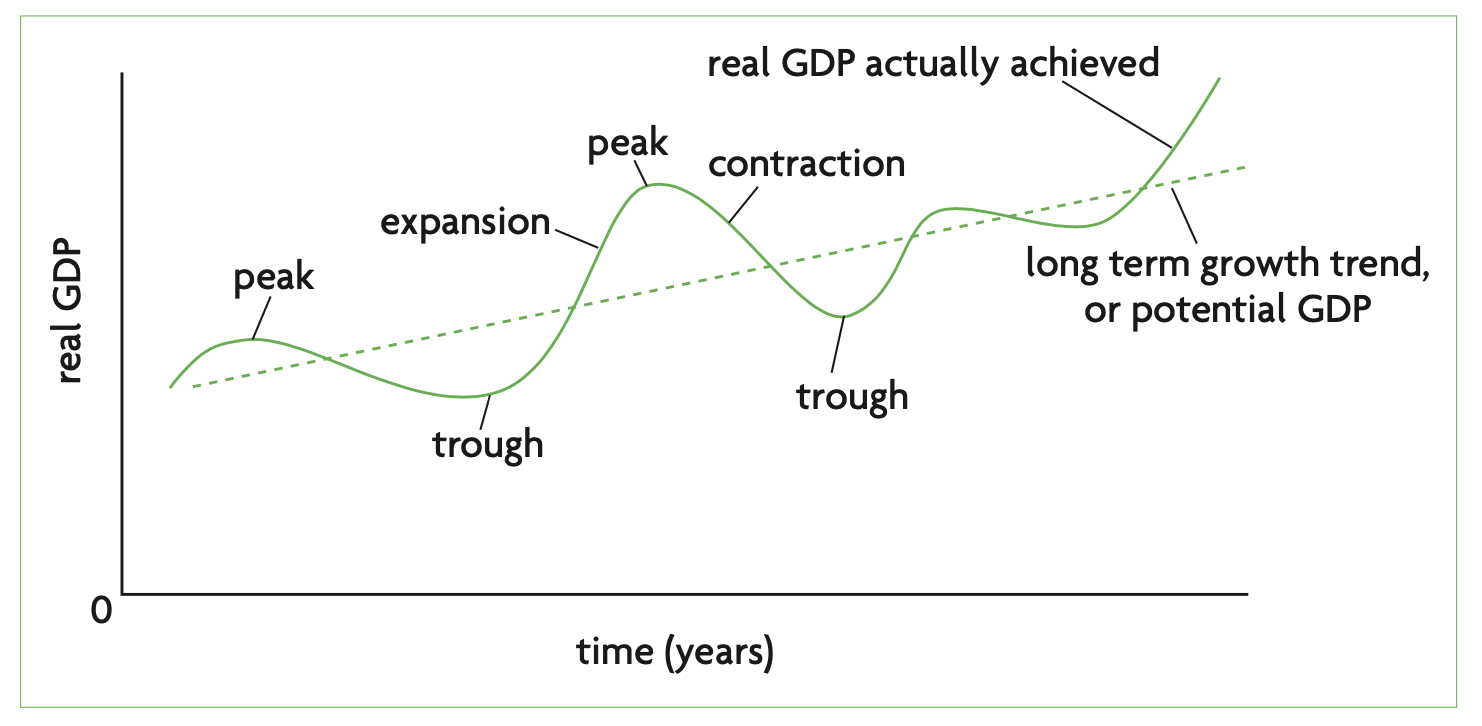

In [ ]:
## analysing patterns of sales across the states CA, TX and WC

sales_by_state_per_day = [(sales_data_df.groupby('state_id').agg({ i : 'sum'})).to_dict('index') for i in d_cols]


sales_CA = [sales_by_state_per_day[i]['CA'] for i in range(0,len(sales_by_state_per_day)) if 'CA' in sales_by_state_per_day[i].keys()]
sales_TX = [sales_by_state_per_day[i]['TX'] for i in range(0,len(sales_by_state_per_day)) if 'TX' in sales_by_state_per_day[i].keys()]
sales_WI = [sales_by_state_per_day[i]['WI'] for i in range(0,len(sales_by_state_per_day)) if 'WI' in sales_by_state_per_day[i].keys()]

## Plotting the products

fig = make_subplots(
    rows=3, cols=1, shared_xaxes=False, vertical_spacing=0.08
)

fig.add_trace(go.Scatter(x=np.arange(len(sales_CA)), y=[sales_CA[i]["d_{}".format(i+1)] for i in range(0,len(sales_CA))],name='Sales in California'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sales_TX)), y=[sales_TX[i]["d_{}".format(i+1)] for i in range(0,len(sales_TX))],name='Sales in Texas'),
              row=2, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(sales_WI)), y=[sales_WI[i]["d_{}".format(i+1)] for i in range(0,len(sales_WI))],name='Sales in Wisconsin'),
              row=3, col=1)

fig.update_layout(showlegend=False,height=1200, width=800,
                  title_text="Sales Analysis across CA,TX and WI")
fig.show()


* Alright, we have a general increasing trend in the sales numbers for all the states.
* Another thing to notice is the drop in sales(seasonality) in all states on a particular day each year which are interestingly seperated by 365 days. Let's check if there are any events on the day this drop takes place.

In [ ]:
### To analyse the drop in sales across all states on Day number 331,697,1062,1427 and 1792
drop_sales_dates = ['d_331','d_697','d_1062','d_1427','d_1792']
[calendar_df[calendar_df['d']==i][['event_name_1','event_type_1']] for i in drop_sales_dates]

As expected behaviour, the sudden drop in sales is due to Christmas Day.

In [ ]:
### NOW WE CHECK SALES ACROSS ALL THE STORES ###
def store_sales(state,row,fig):
    stores  = list(sales_data_df[sales_data_df['state_id']==state]['store_id'].unique())
    df = pd.DataFrame(columns=[i for i in stores])
    for i in range(0,len(stores)):
    
        store_daily_sales = [sum(sales_data_df[sales_data_df["store_id"] == stores[i] ][k] ) for k in d_cols]
        df[stores[i]] = store_daily_sales 
        fig.append_trace(go.Scatter(x=np.arange(90,len(store_daily_sales)), y=df[stores[i]].rolling(90).mean(),name = stores[i]),row=row,col=1)
        fig.update_layout(showlegend=False,height=800, width=1100,
            title_text="Sales Analysis across all stores")
    
fig = make_subplots(rows=3,cols=1,vertical_spacing = 0.08)        
store_sales('CA',1,fig)
store_sales('TX',2,fig)
store_sales('WI',3,fig)
fig.show()

1. Sales across all the stores GENERALLY show a increasing trend in sales across time.
2. There's almost a sine pattern in the sales in the form of waves(with varying amplitude) for **ALMOST** all the stores
3. Few stores like WI_3 and CA_2 have sales going in the downward direction then improve at the end

Now let's look further and try to understand whether selling price has insights too or not!

Let's pick up a random product and check it's selling price affected over time across all stores

In [ ]:
fig = go.Figure()
def sell_price_per_store(store_id):
    np.random.seed(0)
    random_product_id = sell_prices_df['item_id'].sample(n=1).to_string().split('    ')[1]
    random_product_price = sell_prices_df[(sell_prices_df['item_id']==random_product_id) & (sell_prices_df['store_id']==store_id)]
    fig.add_trace(go.Scatter(x=sorted(random_product_price['wm_yr_wk']),y = random_product_price['sell_price'],name = store_id))
for i in list(sell_prices_df['store_id'].unique()):
    sell_price_per_store(i)
fig.show()    

Observations:

    - Price of the product show a similar pattern in price increase across all stores
    - But in the initial phases, the price deviation is high, like for store TX_3, the price is 2.78 USD, and another store in Texas has price 3.48 USD (TX_2)
    - Maybe the stores must have discussed policies to keep the prices same across all states and stores, hence the similar pattern in pricing

**To do:

Forecasting Model


# ***Any kind of Feedback is highly appreciated *** 